In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn import metrics # for calculating Silhouette score
from scipy.stats import multivariate_normal
from scipy.stats import mode
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = np.genfromtxt("/content/drive/MyDrive/Final/datacluster.csv", dtype=float, delimiter=",", usecols=range(1,3), skip_header=1)
data

array([[2.25, 3.47],
       [4.71, 3.6 ],
       [3.17, 4.96],
       [2.32, 1.63],
       [2.31, 2.09],
       [1.14, 2.11],
       [1.9 , 0.97],
       [1.76, 0.84],
       [5.02, 3.02],
       [5.74, 3.84]])

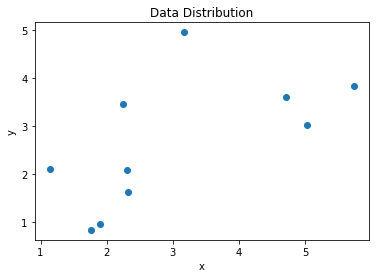

In [ ]:

plt.scatter(data[:, 0], data[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data Distribution')
plt.show()

#Clustering Using GMM Models

In [ ]:
# Select data for clustering model

# Set the model and its parameters - 2 clusters
gmm = GaussianMixture(n_components=2, # this is the number of clusters
                         covariance_type='spherical', # {‘full’, ‘tied’, ‘diag’, ‘spherical’}, default=’full’
                         max_iter=100, # the number of EM iterations to perform. default=100
                         n_init=1, # the number of initializations to perform. default = 1
                         init_params='random', # the method used to initialize the weights, the means and the precisions. {'random' or default='k-means'}
                         verbose=0, # default 0, {0,1,2}
                         random_state=1 # for reproducibility
                        )

# Fit the model and predict labels
gmm.fit(data)
gmm.predict(data)


# Print model summary
print('*************** 2 Cluster Model ***************')
  print('Means: ', gmm.fit(data).means_)
print('Converged: ', gmm.fit(data).converged_)
print(' No. of Iterations: ', gmm.fit(data).n_iter_)


*************** 4 Cluster Model ***************
Means:  [[4.16235163 3.76167183]
 [1.88391687 1.52693676]]
Converged:  True
 No. of Iterations:  16


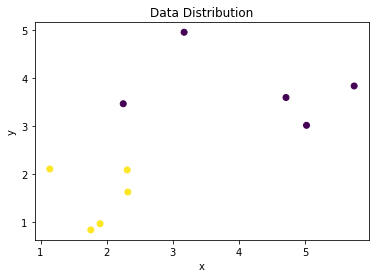

In [ ]:
plt.scatter(data[:, 0], data[:, 1], c=gmm.predict(data))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data Distribution')
plt.show()

##Updating GMM using EM Algorithm

In [ ]:
class GMM:
    def __init__(self, k, max_iter=100):
        self.k = k
        self.max_iter = int(max_iter)

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape

        self.phi = np.full(shape=self.k, fill_value=1/self.k)
        self.weights = np.full( shape=self.shape, fill_value=1/self.k)
        
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [  X[row_index,:] for row_index in random_row ]
        self.sigma = [ np.cov(X.T) for _ in range(self.k) ]

    def e_step(self, X):
        # E-Step: update weights and phi holding mu and sigma constant
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)
    
    def m_step(self, X):
        # M-Step: update mu and sigma holding phi and weights constant
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T, 
                aweights=(weight/total_weight).flatten(), 
                bias=True)

    def fit(self, X):
        self.initialize(X)
        
        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)
            
    def predict_proba(self, X):
        likelihood = np.zeros( (self.n, self.k) )
        for i in range(self.k):
            distribution = multivariate_normal(
                mean=self.mu[i], 
                cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(X)
        
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

In [ ]:
np.random.seed(8)
gmm_em = GMM(k=2)
gmm_em.fit(data)

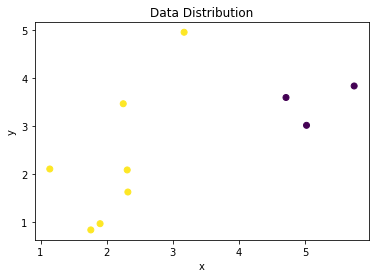

In [ ]:
plt.scatter(data[:, 0], data[:, 1], c=gmm_em.predict(data))
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data Distribution')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
def purity_score(y_true, y_pred):
    """Purity score

    To compute purity, each cluster is assigned to the class which is most frequent 
    in the cluster [1], and then the accuracy of this assignment is measured by counting 
    the number of correctly assigned documents and dividing by the number of documents.
    We suppose here that the ground truth labels are integers, the same with the predicted clusters i.e
    the clusters index.

    Args:
        y_true(np.ndarray): n*1 matrix Ground truth labels
        y_pred(np.ndarray): n*1 matrix Predicted clusters
    
    Returns:
        float: Purity score
    
    References:
        [1] https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html
    """
    # matrix which will hold the majority-voted labels
    y_voted_labels = np.zeros(y_true.shape)
    # Ordering labels
    ## Labels might be missing e.g with set like 0,2 where 1 is missing
    ## First find the unique labels, then map the labels to an ordered set
    ## 0,2 should become 0,1
    labels = np.unique(y_true)
    ordered_labels = np.arange(labels.shape[0])
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
    # Update unique labels
    labels = np.unique(y_true)
    # We set the number of bins to be n_classes+2 so that 
    # we count the actual occurence of classes between two consecutive bin
    # the bigger being excluded [bin_i, bin_i+1[
    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)

    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        # Find the most present label in the cluster
        winner = np.argmax(hist)
        y_voted_labels[y_pred==cluster] = winner
    
    return accuracy_score(y_true, y_voted_labels)

In [ ]:
y_true = gmm.predict(data)
y_pred = gmm_em.predict(data)

print(purity_score(y_true,y_pred))

0.8


In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score

In [ ]:
print(adjusted_rand_score(y_true,y_pred))

0.29411764705882354
